In [5]:
library(tidyverse)
library(data.table)
library(RColorBrewer)
library(MetBrewer)

## Read in filtered 6-base data over regions

In [10]:
modC_cluster<- read_tsv("/data/hodges_lab/6L_seq/data/modC_6L_data.tsv")
dynamic_peaks<- read_tsv("/data/hodges_lab/NPCdiff_ATACme/data/TC_seq/peak_subset_dynamic.bed", 
                         col_names = c("region_chr", "region_start", "region_end", "cluster", "peakID"))
static_peaks<- read_tsv("/data/hodges_lab/NPCdiff_ATACme/data/TC_seq/peak_subset_static.bed", 
                        col_names = c("region_chr", "region_start", "region_end", "peakID")) %>% 
    mutate("cluster" = "static") %>% select(1:3,5,4)

Rows: 282986 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): peakID, cluster, time
dbl (9): reg_mCA, reg_hmCA, reg_unmodCA, reg_mCB, reg_hmCB, reg_unmodCB, reg...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 38189 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): region_chr, peakID
dbl (3): region_start, region_end, cluster

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 63026 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): region_chr, peakID
dbl (2): region_start, region_end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify t

In [11]:
head(modC_cluster)

peakID,cluster,reg_mCA,reg_hmCA,reg_unmodCA,reg_mCB,reg_hmCB,reg_unmodCB,reg_avg_mC,reg_avg_hmC,reg_avg_unmodC,time
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
peak10,static,0.4703406887,0.1183343617,0.37363274,0.3544871795,0.302564103,0.31794872,0.4124139341,0.2104492321,0.34579073,0day
peak100,static,0.0050356641,0.0057640145,0.94746472,0.0105485232,0.004219409,0.94430380,0.0077920936,0.0049917119,0.94588426,0day
peak1000,static,0.0066915733,0.0042753623,0.96276053,0.0021367521,0.004273504,0.97487790,0.0044141627,0.0042744333,0.96881921,0day
peak10000,static,0.0008654318,0.0009377664,0.95724727,0.0009337068,0.000000000,0.96366324,0.0008995693,0.0004688832,0.96045526,0day
peak100000,7,0.8041277779,0.0365444360,0.08765386,0.8716765873,0.068700397,0.02256944,0.8379021826,0.0526224164,0.05511165,0day
peak100001,static,0.8455086580,0.0450487013,0.06493506,0.6473214286,0.062500000,0.22767857,0.7464150433,0.0537743506,0.14630682,0day


## find average modC values across each peak region 

In [21]:
peaks<- rbind(dynamic_peaks, static_peaks)
modC_cluster$time<- factor(modC_cluster$time, levels = c("0day", "4day", "8day"))
modC_cluster_coord<- inner_join(modC_cluster, peaks)
hmC_high_0day<- modC_cluster_coord %>% pivot_wider(id_cols = c(peakID, cluster, region_chr, region_start, region_end), values_from = reg_avg_hmC, names_from = time) %>% 
    filter("0day" >= 0.105324) %>% ungroup() %>% select(-"4day", -"8day", -peakID, -cluster) %>% drop_na() 
hmC_low_0day <- modC_cluster_coord %>% pivot_wider(id_cols = c(peakID, cluster, region_chr, region_start, region_end), values_from = reg_avg_hmC, names_from = time) %>% 
    filter("0day" < 0.105324) %>% ungroup() %>% select(-"4day", -"8day", -peakID, -cluster) %>% drop_na() 

hmC_high_4day<- modC_cluster_coord %>% pivot_wider(id_cols = c(peakID, cluster, region_chr, region_start, region_end), values_from = reg_avg_hmC, names_from = time) %>% 
    filter("4day" >= 0.105324) %>% ungroup() %>% select(-"0day", -"8day", -peakID, -cluster) %>% drop_na() 
hmC_low_4day <- modC_cluster_coord %>% pivot_wider(id_cols = c(peakID, cluster, region_chr, region_start, region_end), values_from = reg_avg_hmC, names_from = time) %>% 
    filter("4day" < 0.105324) %>% ungroup() %>% select(-"0day", -"8day", -peakID, -cluster) %>% drop_na() 

hmC_high_8day<- modC_cluster_coord %>% pivot_wider(id_cols = c(peakID, cluster, region_chr, region_start, region_end), values_from = reg_avg_hmC, names_from = time) %>% 
    filter("8day" >= 0.105324) %>% ungroup() %>% select(-"0day", -"4day", -peakID, -cluster) %>% drop_na()
hmC_low_8day <- modC_cluster_coord %>% pivot_wider(id_cols = c(peakID, cluster, region_chr, region_start, region_end), values_from = reg_avg_hmC, names_from = time) %>% 
    filter("8day" < 0.105324) %>% ungroup() %>% select(-"0day", -"4day", -peakID, -cluster) %>% drop_na()


Joining with `by = join_by(peakID, cluster)`


In [22]:
summary(modC_cluster)

#high/low classification based on distribution of reg_avg_hmC, top 25% is high, bottom 75% is low
modC_hmC_subsets<- modC_cluster %>% mutate(hmC_level = case_when(reg_avg_hmC >=0.105324 ~ "high", 
                            reg_avg_hmC < 0.105324 ~ "low"))
modC_hmC_subsets$cluster<- factor(modC_hmC_subsets$cluster, levels = c(3,1,2,6,4,7,5, "static"))

    peakID            cluster             reg_mCA           reg_hmCA       
 Length:282986      Length:282986      Min.   :0.00000   Min.   :0.000000  
 Class :character   Class :character   1st Qu.:0.02078   1st Qu.:0.004785  
 Mode  :character   Mode  :character   Median :0.16374   Median :0.045455  
                                       Mean   :0.24092   Mean   :0.068266  
                                       3rd Qu.:0.40827   3rd Qu.:0.106838  
                                       Max.   :1.00000   Max.   :0.750000  
  reg_unmodCA        reg_mCB            reg_hmCB        reg_unmodCB    
 Min.   :0.0000   Min.   :0.000000   Min.   :0.00000   Min.   :0.0000  
 1st Qu.:0.3846   1st Qu.:0.006918   1st Qu.:0.00000   1st Qu.:0.4000  
 Median :0.6901   Median :0.150000   Median :0.02778   Median :0.7083  
 Mean   :0.6332   Mean   :0.239917   Mean   :0.06919   Mean   :0.6417  
 3rd Qu.:0.9203   3rd Qu.:0.407407   3rd Qu.:0.10667   3rd Qu.:0.9222  
 Max.   :1.0000   Max.   :1.000000  

## Plot Figure 5H

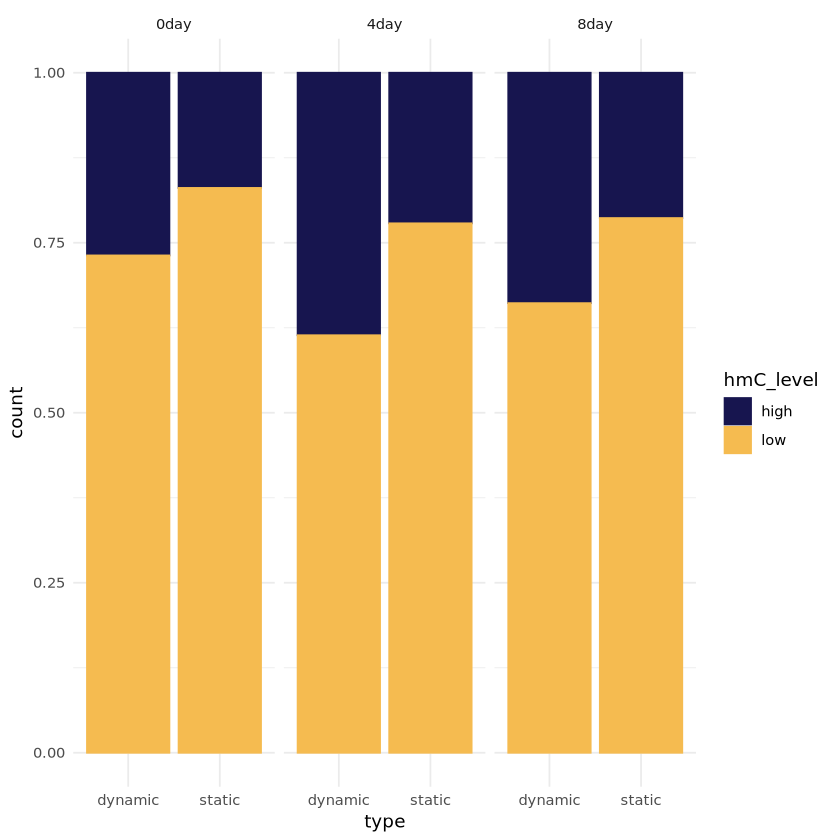

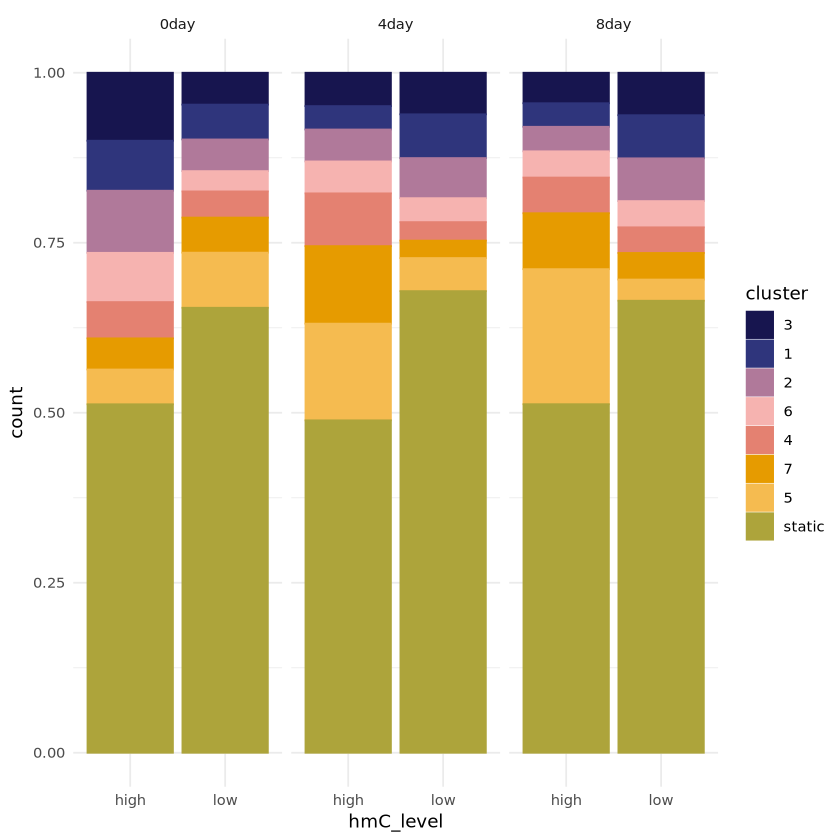

In [23]:
modC_hmC_subsets_g <- mutate(modC_hmC_subsets, type = case_when(cluster == "static" ~ "static", .default = "dynamic"))
hmC_barplot_subsets<- ggplot(modC_hmC_subsets_g, aes(x= type, color = hmC_level, fill = hmC_level))+
  geom_bar(position = "fill")+
  scale_fill_manual(values=met.brewer("Renoir", 2))+
  scale_color_manual(values=met.brewer("Renoir", 2))+
  facet_wrap(~time)+
  theme_minimal()
hmC_barplot_subsets


## Chi-squared calculation for Figure 5H

`summarise()` has grouped output by 'time'. You can override using the
`.groups` argument.


time,hmC_level,count
<fct>,<chr>,<int>
0day,high,10024
0day,low,49154
4day,high,12967
4day,low,45586
8day,high,12642
8day,low,46514


`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


,dynamic,static
,<int>,<int>
high,9536,10024
low,25959,49154



	Pearson's Chi-squared test with Yates' continuity correction

data:  df_0
X-squared = 411.67, df = 1, p-value < 2.2e-16


`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


,dynamic,static
,<int>,<int>
high,13559,12967
low,21565,45586



	Pearson's Chi-squared test with Yates' continuity correction

data:  df_4
X-squared = 817.3, df = 1, p-value < 2.2e-16


`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


,dynamic,static
,<int>,<int>
high,12022,12642
low,23458,46514



	Pearson's Chi-squared test with Yates' continuity correction

data:  df_8
X-squared = 375.7, df = 1, p-value < 2.2e-16


ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34m/Users/lindsey/Desktop/Hodges_Lab/ATAC-me[39m
  [34mNPCdiff/NPCDiff_ATACme/New_timepoints/Figures[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


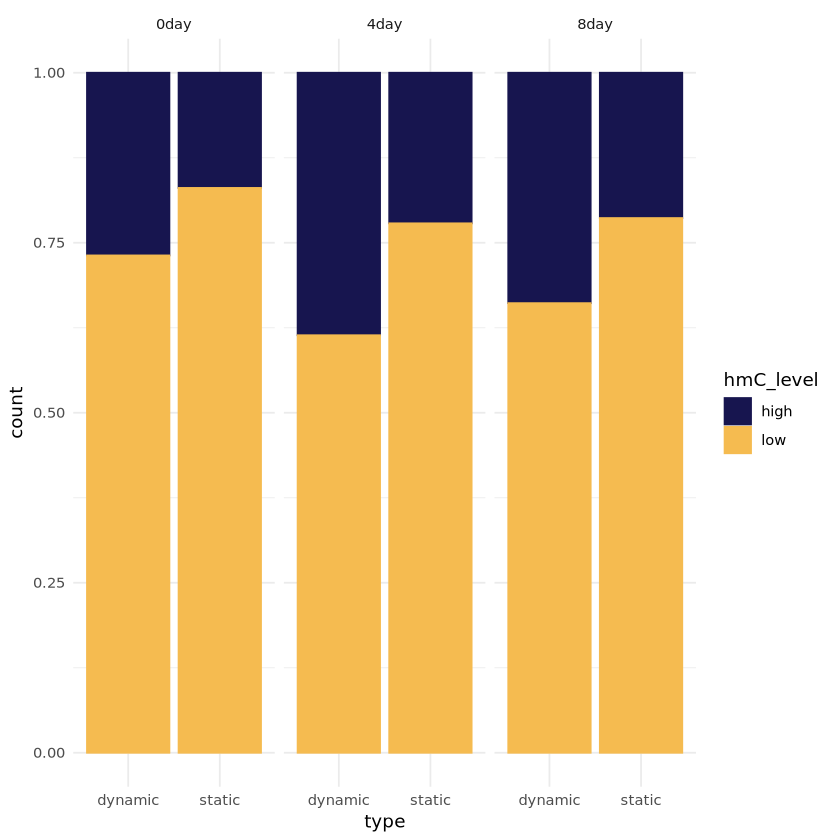

In [42]:
modC_hmC_subsets_sum <- filter(modC_hmC_subsets, cluster == "static") %>% group_by(time, hmC_level) %>% summarise(count = n())
modC_hmC_subsets_sum

modC_hmC_subsets_g <- mutate(modC_hmC_subsets, type = case_when(cluster == "static" ~ "static", .default = "dynamic"))
chisq_0<- modC_hmC_subsets_g %>% filter(time =="0day") %>% group_by(type, hmC_level) %>% summarize(count = n()) %>% pivot_wider(names_from = type, values_from = count) %>% column_to_rownames(var = "hmC_level")
chisq_0
#expected based on static ratio (10024/49154) is 0.203930504129878
obs_0<-c(chisq_0$dynamic)
exp_0<- c(sum(obs_0)*0.203930504129878,sum(obs_0)*(1-0.203930504129878))
df_0<- data.frame(obs_0, exp_0)
chisq_0_res<- chisq.test(df_0)
chisq_0_res

chisq_4<- modC_hmC_subsets_g %>% filter(time =="4day") %>% group_by(type, hmC_level) %>% summarize(count = n()) %>% pivot_wider(names_from = type, values_from = count) %>% column_to_rownames(var = "hmC_level")
chisq_4
#expected based on static ratio (12967/45586) is 0.284451366647655
obs_4<-c(chisq_4$dynamic)
exp_4<- c(sum(obs_0)*0.284451366647655,sum(obs_0)*(1-0.284451366647655))
df_4<- data.frame(obs_4, exp_4)
chisq_4_res<- chisq.test(df_4)
chisq_4_res

chisq_8<- modC_hmC_subsets_g %>% filter(time =="8day") %>% group_by(type, hmC_level) %>% summarize(count = n()) %>% pivot_wider(names_from = type, values_from = count) %>% column_to_rownames(var = "hmC_level")
chisq_8
#expected based on static ratio (12642/46514) is 0.271789138753924
obs_8<-c(chisq_8$dynamic)
exp_8<-c(sum(obs_8)*0.271789138753924,sum(obs_8)*(1-0.271789138753924))
df_8<- data.frame(obs_8, exp_8)
chisq_8_res<- chisq.test(df_8)
chisq_8_res